# Get AVIRIS-NG for multiple points

In [1]:
# import python modules
from os import path
import numpy as np
import geopandas as gpd
import pandas as pd
import s3fs
import rioxarray
from pyproj import Proj
import matplotlib.pyplot as plt

# initialize S3 file system
s3 = s3fs.S3FileSystem(anon=False)

## Read Vegetation centers
The `CapePeninsulaVegCenters.geojson` contains the centroids of all vegetation plots within the Cape Peninsula region.

In [2]:
vegcenter = 'DominantFamPlotCenters.geojson'
v_gdf = gpd.read_file(vegcenter)
# keep only the columns we need
v_gdf = v_gdf[['BScpPID','Region','Name', 'QltyFlg', 'DominantFamily', 'geometry']]
v_gdf.head()

,BScpPID,Region,Name,QltyFlg,DominantFamily,geometry
0,T097,CapePeninsula,Peninsula_97,Low vegetation cover,Restionaceae,POINT (18.38651 -34.23869)
1,T093,CapePoint,CapePoint_93,None,Asteraceae,POINT (18.41285 -34.25000)
2,T077,CapePoint,CapePoint_77,Low vegetation cover,Proteaceae,POINT (18.42829 -34.29327)
3,T085,CapePoint,CapePoint_85,None,Ericaceae,POINT (18.42937 -34.31180)
4,T068,CapePoint,CapePoint_68,On Boundary,Restionaceae,POINT (18.44538 -34.32458)


Following shows number of plots by Dominant Family.

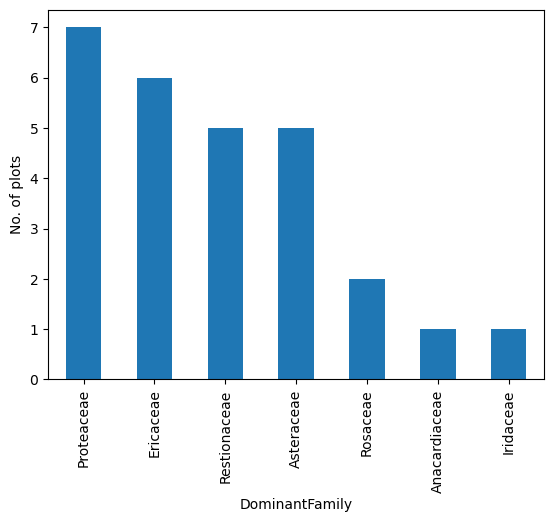

In [3]:
v_gdf.DominantFamily.value_counts().plot(kind="bar", ylabel="No. of plots")
plt.show()

## Read AVIRIS-NG Bounding Polygons
The `ANG_Coverage.geojson` file contains two columns `fid` and `scid` which will help us identify the AVIRIS-NG granules and their folder structure.

In [4]:
ang_cov = 'ANG_Coverage.geojson'
a_gdf = gpd.read_file(ang_cov)
# keep only the columns we need
a_gdf = a_gdf[['fid', 'scid', 'start_time', 'geometry']]
a_gdf.head()

,fid,scid,start_time,geometry
0,ang20231022t092801,ang20231022t092801_000,2023-10-22 09:28:01+00:00,"POLYGON ((18.75671 -32.94696, 18.79830 -32.945..."
1,ang20231022t092801,ang20231022t092801_001,2023-10-22 09:28:01+00:00,"POLYGON ((18.76213 -32.97934, 18.80428 -32.977..."
2,ang20231022t092801,ang20231022t092801_002,2023-10-22 09:28:01+00:00,"POLYGON ((18.76979 -33.01113, 18.81188 -33.009..."
3,ang20231022t092801,ang20231022t092801_003,2023-10-22 09:28:01+00:00,"POLYGON ((18.77388 -33.04254, 18.81612 -33.041..."
4,ang20231022t092801,ang20231022t092801_004,2023-10-22 09:28:01+00:00,"POLYGON ((18.77544 -33.07394, 18.81786 -33.072..."


Following shows number of flights by day of the year (2023).

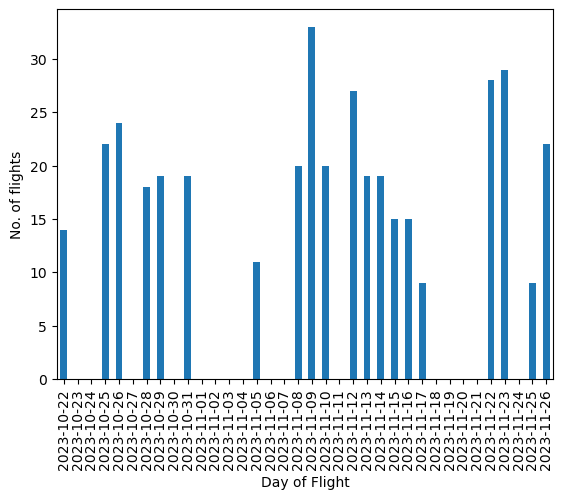

In [5]:
a_gdf['start_time'] = pd.to_datetime(a_gdf['start_time'])
ang_daily_fid = a_gdf.resample(rule='D', on='start_time')['fid'].nunique()
ang_daily_fid.index = pd.to_datetime(ang_daily_fid.index).date
ang_daily_fid.plot(kind="bar", xlabel="Day of Flight", ylabel="No. of flights")
plt.show()

## Get AVIRIS-NG spectra for the center coordinates
We will retrieve AVIRIS-NG spectra of the center veg plot coordinates and save it as a CSV file.

First, find the vegetation points that are within the AVIRIS-NG polygons.

In [6]:
# spatial join of the veg plots and the ANG polygons dataframes
veg_ang_df = gpd.sjoin(v_gdf, a_gdf, predicate = 'within')
# adding X, Y columns
veg_ang_df['X'] = veg_ang_df.geometry.x
veg_ang_df['Y'] = veg_ang_df.geometry.y
# print
ang_plots_n = len(veg_ang_df.scid.unique())
ang_n = len(a_gdf.scid.unique())
print(f"{ang_plots_n} of {ang_n} AVIRIS-NG files overlaps with the veg plots")

94 of 9558 AVIRIS-NG files overlaps with the veg plots


As we see above, there are 94 AVIRIS-NG files that overlaps with the veg plots in Cape Town Penninsula. Let's also look at the top few rows of the joined dataframe.

In [7]:
veg_ang_df.head()

,BScpPID,Region,Name,QltyFlg,DominantFamily,geometry,index_right,fid,scid,start_time,X,Y
0,T097,CapePeninsula,Peninsula_97,Low vegetation cover,Restionaceae,POINT (18.38651 -34.23869),4228,ang20231109t134249,ang20231109t134249_017,2023-11-09 13:42:49+00:00,18.386513,-34.238689
0,T097,CapePeninsula,Peninsula_97,Low vegetation cover,Restionaceae,POINT (18.38651 -34.23869),4236,ang20231109t135449,ang20231109t135449_003,2023-11-09 13:54:49+00:00,18.386513,-34.238689
0,T097,CapePeninsula,Peninsula_97,Low vegetation cover,Restionaceae,POINT (18.38651 -34.23869),5383,ang20231113t104533,ang20231113t104533_003,2023-11-13 10:45:33+00:00,18.386513,-34.238689
0,T097,CapePeninsula,Peninsula_97,Low vegetation cover,Restionaceae,POINT (18.38651 -34.23869),9364,ang20231126t105818,ang20231126t105818_010,2023-11-26 10:58:18+00:00,18.386513,-34.238689
0,T097,CapePeninsula,Peninsula_97,Low vegetation cover,Restionaceae,POINT (18.38651 -34.23869),9435,ang20231126t110802,ang20231126t110802_032,2023-11-26 11:08:02+00:00,18.386513,-34.238689


Let's first define two python functions.

In [8]:
def get_rfl_path(fid_str, scid_str):
    """returns s3 paths from fid and scid for aviris-ng files"""
    # list the ANG files
    a_fs = s3.ls(f'bioscape-data/AVNG/{fid_str}/{scid_str}')
    # loop through the file list and find the RFL file
    a_rfl = [a_f for a_f in a_fs if a_f.endswith("_RFL_ORT")][0]
    return path.join('s3://', a_rfl)

def subset_avirisng(rfl_xr, a_df):
    """returns a pandas dataframe with band names and spectral value 
    for a pixel"""
    # Proj class instance with AVN CRS. preserve_units false to ensure 
    # that input coordinates are in meters
    p = Proj(rfl_xr.rio.crs, preserve_units=False)
    # converts the lon,lat veg plot coordinates to the ANG map projection
    x, y = p(a_df.X, a_df.Y)
    # get the spectra of the ANG pixel nearest to the veg plot
    rfl_val = rfl_xr.sel(y=y, x=x, method='nearest').to_numpy()
    # get band names
    band_names = [f'Band_{i}' for i in a_rfl_xr.band.to_numpy()] 
    # convert band and spectra into a dataframe
    rfl_dict = dict(zip(band_names, rfl_val))
    rfl_df = pd.DataFrame([rfl_dict])  
     # add Name, scid columns which we will use to join dataframes later
    rfl_df['Name'] = a_df.Name
    rfl_df['scid'] = a_df.scid
    return rfl_df

Now, we can run the subsetting of AVIRIS-NG files over the vegetation plots. This operation might take some time. For saving time, let's run for the first 30 plots (we have 94 plots over Cape Penninsula).

In [9]:
# initialize a list for storing aviris dataframe
rfl_list = []
# total number of veg plots to process
sub_n = 30
# loop through AVNG files by scid
for i, scid in enumerate(veg_ang_df.scid.unique()[:sub_n]):
    # get row(s) that matches scid
    a_temp_df = veg_ang_df[veg_ang_df['scid']==scid]
    # retrieve S3 path of the AVIRIS tile
    a_rfl = get_rfl_path(a_temp_df.fid.values[0], scid)
    print(f'reading {i+1} of {sub_n}: {path.basename(a_rfl)}')
    # open the RFL file
    a_rfl_xr = rioxarray.open_rasterio(a_rfl, drivers='ENVI', 
                                       chunks=True, parse_coordinates=True)
    # loop through the veg plots
    for s in a_temp_df.index:
        # get a row
        a_temp = a_temp_df.loc[s]       
        rfl_list.append(subset_avirisng(a_rfl_xr, a_temp))

# concatenate ANG spectra dataframe
avng_rfl_df = pd.concat(rfl_list)
# merge it with the a_sub_gdf dataframe
final_gdf = pd.merge(veg_ang_df, avng_rfl_df, on=["scid", "Name"], how="left")

reading 1 of 30: ang20231109t134249_017_L2A_OE_main_27577724_RFL_ORT
reading 2 of 30: ang20231109t135449_003_L2A_OE_main_27577724_RFL_ORT
reading 3 of 30: ang20231113t104533_003_L2A_OE_main_27577724_RFL_ORT
reading 4 of 30: ang20231126t105818_010_L2A_OE_main_27577724_RFL_ORT
reading 5 of 30: ang20231126t110802_032_L2A_OE_main_27577724_RFL_ORT
reading 6 of 30: ang20231109t133124_003_L2A_OE_main_27577724_RFL_ORT
reading 7 of 30: ang20231113t131251_017_L2A_OE_main_27577724_RFL_ORT
reading 8 of 30: ang20231126t101852_010_L2A_OE_main_27577724_RFL_ORT
reading 9 of 30: ang20231126t102854_041_L2A_OE_main_27577724_RFL_ORT
reading 10 of 30: ang20231109t131923_019_L2A_OE_main_27577724_RFL_ORT
reading 11 of 30: ang20231109t133124_002_L2A_OE_main_27577724_RFL_ORT
reading 12 of 30: ang20231113t131251_019_L2A_OE_main_27577724_RFL_ORT
reading 13 of 30: ang20231113t132348_002_L2A_OE_main_27577724_RFL_ORT
reading 14 of 30: ang20231126t094733_048_L2A_OE_main_27577724_RFL_ORT
reading 15 of 30: ang20231126

The following will export the pandas dataframe to a CSV file. 

In [10]:
# write it to CSV
# final_gdf.to_csv('ANG_RFL_CapePeninsulaVegCenters.csv', index=False)
final_gdf = pd.read_csv('ANG_RFL_CapePeninsulaVegCenters.csv')

We will now plot by the dominant family.

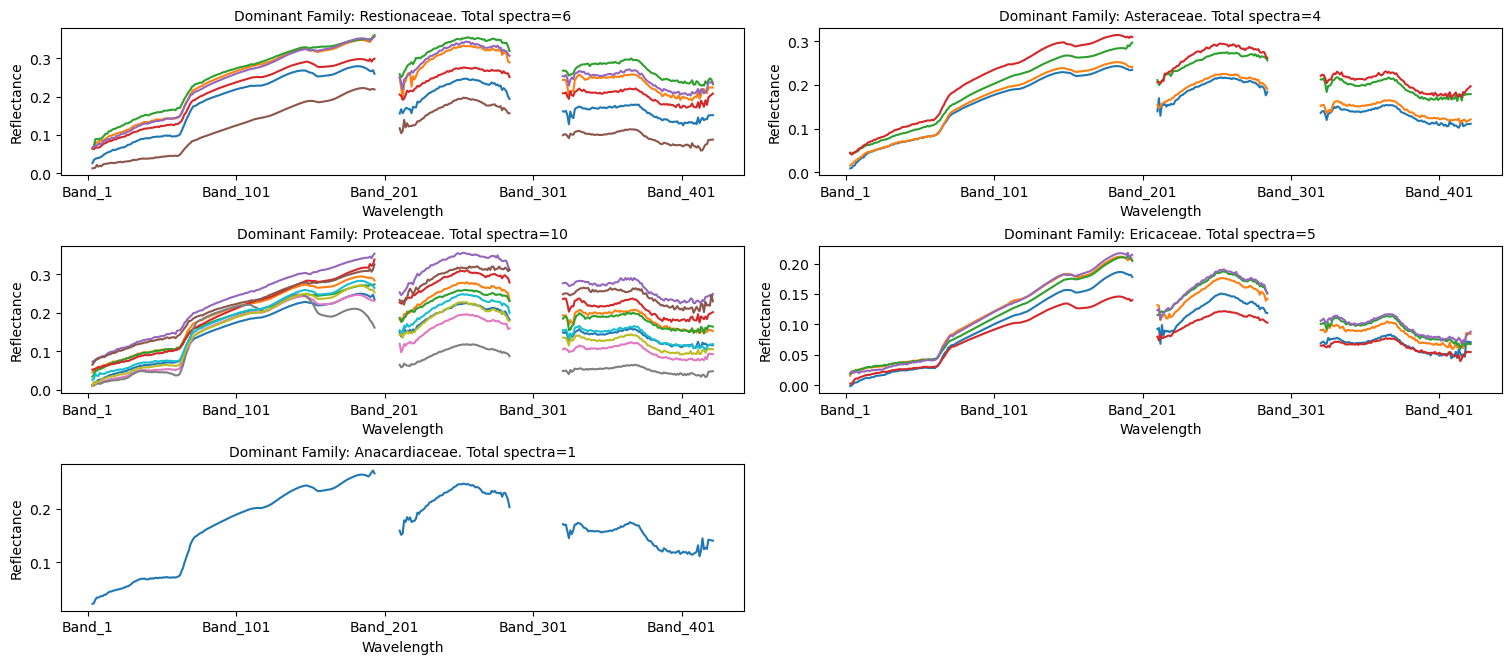

In [11]:
dominant = final_gdf.DominantFamily.unique()
fig = plt.figure(figsize=(15,8), constrained_layout=True)
columns = 2
rows = int(len(dominant)/columns)+1
for i, item in enumerate(dominant):
    # transpose and plot species
    dominant_df = final_gdf[final_gdf.DominantFamily == item]
    dominant_df = dominant_df.filter(like='Band')
    # drop rows with no data values
    dominant_df = dominant_df.replace(-9999, pd.NA).dropna()
    if not dominant_df.empty:
        # setting tails and atmospheric window to nan values
        dominant_df.iloc[:, np.r_[:3,194:210,285:320,422:425]] = np.nan
        dominant_n = len(dominant_df.index)
        ax = fig.add_subplot(rows, columns, i+1)
        dominant_df.T.plot(ax=ax, legend=None, 
                           xlabel="Wavelength", ylabel="Reflectance")
        # ax.set_xticks(a_rfl_xr.wavelength.values.tolist())
        ax.set_title(f"Dominant Family: {item}. Total spectra={len(dominant_df.index)}", 
                     fontsize=10)

plt.show()

## Get AVIRIS-NG spectra for a buffer around the center plot coordinates
We will now retrieve AVIRIS-NG spectra of a 1-pixel buffer (3 x 3 pixels) around the center veg plot coordinates and save it as a CSV file.

First, find the vegetation points that are within the AVIRIS-NG polygons.

In [12]:
def subset_avirisng_buffer(rfl_xr, a_df, b):
    """returns a pandas dataframe with band names and spectral value 
    for a pixel"""
    # Proj class instance with AVN CRS. preserve_units false to ensure 
    # that input coordinates are in meters
    p = Proj(rfl_xr.rio.crs, preserve_units=False)
    # converts the lon,lat veg plot coordinates to the ANG map projection
    x, y = p(a_df.X, a_df.Y)
    # get the spectra of the ANG pixel nearest to the veg plot
    ix = list(a_rfl_xr.x.values).index(a_rfl_xr.sel(x=x, method='nearest').x)
    iy = list(a_rfl_xr.y.values).index(a_rfl_xr.sel(y=y, method='nearest').y)
    rfl_val = a_rfl_xr.isel(y=slice(iy-b, iy+b+1), 
                            x=slice(ix-b, ix+b+1)).values
    # get band names
    band_names = [f'Band_{i}' for i in a_rfl_xr.band.to_numpy()] 
    # convert band and spectra into a dataframe
    rfl_dict = dict(zip(band_names, rfl_val))
    rfl_df = pd.DataFrame([rfl_dict])  
     # add Name, scid columns which we will use to join dataframes later
    rfl_df['Name'] = a_df.Name
    rfl_df['scid'] = a_df.scid
    return rfl_df

Now, run for only the first plot.

In [14]:
# initialize a list for storing aviris dataframe
rfl_list = []
# total number of veg plots to process
sub_n = 1
# loop through AVNG files by scid
for i, scid in enumerate(veg_ang_df.scid.unique()[:sub_n]):
    # get row(s) that matches scid
    a_temp_df = veg_ang_df[veg_ang_df['scid']==scid]
    # retrieve S3 path of the AVIRIS tile
    a_rfl = get_rfl_path(a_temp_df.fid.values[0], scid)
    print(f'reading {i+1} of {sub_n}: {path.basename(a_rfl)}')
    # open the RFL file
    a_rfl_xr = rioxarray.open_rasterio(a_rfl, drivers='ENVI', 
                                       chunks=True, parse_coordinates=True)
    # loop through the veg plots
    for s in a_temp_df.index:
        # get a row
        a_temp = a_temp_df.loc[s]
        # subset around 1 pixel
        rfl_list.append(subset_avirisng_buffer(a_rfl_xr, a_temp, 1))

# concatenate ANG spectra dataframe
avng_rfl_df = pd.concat(rfl_list)
# merge it with the a_sub_gdf dataframe
final_gdf = pd.merge(veg_ang_df, avng_rfl_df, on=["scid", "Name"], how="left")

reading 1 of 1: ang20231109t134249_017_L2A_OE_main_27577724_RFL_ORT


Let's print the first row of the dataframe.

In [16]:
final_gdf[:1]

,BScpPID,Region,Name,QltyFlg,DominantFamily,geometry,index_right,fid,scid,start_time,...,Band_416,Band_417,Band_418,Band_419,Band_420,Band_421,Band_422,Band_423,Band_424,Band_425
0,T097,CapePeninsula,Peninsula_97,Low vegetation cover,Restionaceae,POINT (18.38651 -34.23869),4228,ang20231109t134249,ang20231109t134249_017,2023-11-09 13:42:49+00:00,...,"[[0.1349716, 0.13286367, 0.16402882], [0.12452...","[[0.13877362, 0.14005977, 0.17094846], [0.1336...","[[0.13524158, 0.12604173, 0.16354012], [0.1311...","[[0.15127821, 0.13077939, 0.1757726], [0.14373...","[[0.15161276, 0.1304597, 0.17584562], [0.14405...","[[0.15180111, 0.13008583, 0.17584026], [0.1442...","[[0.15198155, 0.12965338, 0.17580955], [0.1444...","[[0.15216568, 0.12926476, 0.17578737], [0.1445...","[[0.15237422, 0.12887794, 0.17577627], [0.1447...","[[-0.01, -0.01, -0.01], [-0.01, -0.01, -0.01],..."


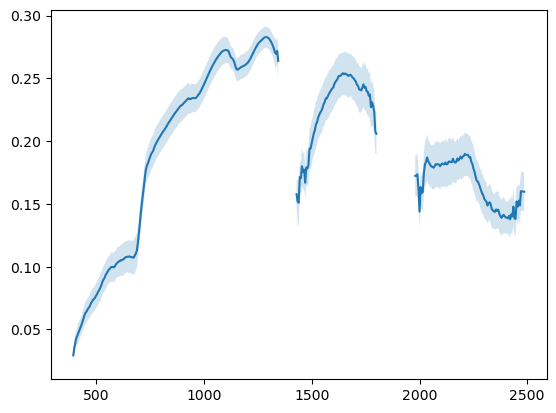

In [34]:
first_df = final_gdf[:1]
first_df = first_df.filter(like='Band')
first_df.iloc[:, np.r_[:3,194:210,285:320,422:425]] = np.nan
mean_df = first_df.map(np.mean).T
std_df = first_df.map(np.std).T
fig, ax = plt.subplots()
wavelength = a_rfl_xr.wavelength.values.tolist()
ax.plot(wavelength, mean_df, '-')
ax.fill_between(wavelength, (mean_df - std_df)[0], (mean_df + std_df)[0], alpha=0.2)